# Advanced Machine Learning - programming assignment 1

*Due: Friday December 1st*

**Please fill in:**
* Sotiris Zenios (8657785)
* Andreas Alexandrou (9503978)

### Further instructions:
* Code quality is considered during the assessment. Make sure your code is properly commented. 
* Submit your code in Blackboard using **one** of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name (i.e. submitter_collaborator.ipynb). 
* **Failure to follow these instructions can affect the assignment grade.**

## Multi-armed Bandits

In this programming assignment, we will look at how we can solve a k-armed bandit problem as discussed in the lecture. Expect for winning at the slot machines, you are expect to better understand the tradeoff between exploration and exploiation. 

Here are the objectives of this assignment:
1.   Get familier with the Open-AI gym/gymnasium environment,
2.   Implement your own k-armed bandit environment based on the gym framework,
3.   Use an epsilon-greedy algorithm to find the optimal action for this k-armed bandit problem,
4.   Play with the parameter epsilon and identify a reasonable setting for balancing exploration and exploiation. 
    

### 0. Please check the given 'README' file

### 1. Let's start with the OpenAI gym

Gym/Gymnasium (https://gymnasium.farama.org/) is a wide-used toolkit for developing and comparing reinforcement learning algorithms. 

1. Gym/Gymnasium makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano. 

2. The library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

**Great!** Now let's import the gym class and work on a basic example of gym code.


In [9]:
import gymnasium

Like mentioned above, gym's main purpose is to provide a large collection of **environments** that expose a common interface. You can find a listing of those environments below (they are Markov decision process(MDP) environments and we will discuss MDP in our lecture 11), as follows:

In [10]:
from gymnasium import envs
print(envs.registry)

{'CartPole-v0': EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'CartPole-v1': EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'MountainCar-v0': EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_thr

We are now going to explain how the RL framework of gym works. 
- An **ENVIRONMENT**, 
- You also have an **AGENT**,
- The agent takes an **ACTION**, in our case, 10 actions are possible to take,
- When a single **ACTION** is chosen and fed to our **ENVIRONMENT**, the **ENVIRONMENT** measures how good the action was taken and produces a **REWARD**, which is usually a numeric value.

In MDP problems, the **ENVIRONMENT** will also provides an **OBSERVATION**, which represets the state of the **ENVIRONMENT** at the current moment. In the multi-armed bandit problems, there is no **OBSERVATION** (or state). You may understand this better after the lecture about Markov decision process (MDP). 

Please read the 'Basic usage' https://gymnasium.farama.org/content/basic_usage/ for better understanding the framework. 


### 2. Implement your own environment

Next, we are going to implement our own environment following the framework of gym. This enviroment is a gambiling room with ten different slot machines (a 10-armed bandit problem). Similar with examples given in the lecture, the reward of each slot machine follows a normal distribution, but the average reward (mean) and variance of each action are different. Your goal is to determine the optimal action from all possible actions/machines. 

The core gym interface is **Env**, which is the unified environment interface. There is no interface for agents. The following are the Env methods you should know:

- `step(self, action)`: Steps the environment by one timestep. Returns observation, reward, done, info.
- `reset(self)`: Resets the environment to an initial state. Returns an initial observation. Each call of `reset()` should yield an environment suitable for a new episode, independent of previous episodes. Because there is no state transition in multi-armed bandit problems, this function is not used here.
- `render(self, mode='human')`: Renders one frame of the environment. The default mode will do something human friendly, such as pop up a window. In this assignment, there is no need to create a pop up window. 

Before writing your own codes, read through the readme of github page of gymasium (https://github.com/Farama-Foundation/Gymnasium). You are also recommended to read at least the codes for one simple environment and one example agent.

#### 2.1 Self-defined Slot Machine

**Please fill in the missing codes in the function sample (1 point).**

In [11]:
import numpy as np

class slotMachine:
    """
        A slot machine contains a reward distribution that randomly generated with restricted mean and standard deviation. 
            sample function: generates a reward at each time step based on the given reward distribition
    """
    def __init__(self):
        self.mu = np.random.uniform(-5, 5)  # mean
        self.sigma = np.random.uniform(0.5, 1)  # standard deviation

    def sample(self):
       return  np.random.normal(self.mu, self.sigma)


#### 2.2 Game Environment
**Please fill in the missing codes in function step (1 point) in the environment.** 

In [26]:
from gymnasium import spaces

# The environment has to inherit the interface of gymnasium.Env
class GamblingRoom(gymnasium.Env):
    """
    A k-armed bandit environment: a gambling room with slot machines, allows the agents to interact with it.
        r_machines: A list of slot machines, each gamblingRoom contains k number of slotMachines
    """
    def __init__(self, k, seed=None):
        # initialize reward distribution for each action/machine
        self.r_machines = []
        for i in range(k):
            # each gamblingRoom contains k number of slotMachines
            self.r_machines.append(slotMachine())

        self.num_arms = k
        self.action_space = spaces.Discrete(self.num_arms)
        self.observation_space = spaces.Discrete(1)
        # for our bandit environment, the state is constant
        self.state = 0
        self.seed(seed)
        self.optimalM = max(range(k), key = lambda x : self.r_machines[x].mu)
    
    # step up the environment based on the selected action,
    # return the constant state, reward, done = false, and info 
    # for now, we do not have to worry about the DONE and INFO variables.
    def step(self, action):
        assert self.action_space.contains(action)
        done = False
        reward=self.r_machines[action].sample()

        
        return self.state, reward, done, {}

    # random seed used for reproducibility purposes
    def seed(self, seed):
        if seed is not None:
            np.random.seed(seed)
    
    def reset(self):
        pass

    def render(self, mode='human', close=False):
        pass

    def close(self):
        pass

# room= GamblingRoom(10)
# print(room.step(0))
# print(room.step(1))
# print(room.step(2))

### 3. Implement an agent with the epsilon greedy algorithm

In this part, you are expected to implement an RL agent. To decide the action to take at each time step, this agent uses the epsilon greedy algorithm introduced in the lecture.

**Please fill in the missing codes in function select_action (1.5 points) and update_parameters (1 point) in the agent.** Feel free to import the needed packages if there are any.

In [27]:
class EplisonGreedyAgent:
    def __init__(self, k, e):
        # set up the number of arms/actions
        self.num_arms = k
        # set up the value of epsilon
        self.epsilon = e
        # init the estimated values of all actions
        self.Qvalues = np.zeros(k)
        # init the numbers of time step that every action is selected
        self.stepSize = np.zeros(k)

    ##
    # select the action to take at the current time step
    # (for MDP, choose the action based on state; for k-armed bandit, no state given)
    # return: the action to take
    ##
    def select_action(self):
        ########## TODO: to be filled. ##########
        if np.random.uniform(0,1) < self.epsilon:
            return (int)(np.random.uniform(0,10))
        else:
            return np.argmax(self.Qvalues)

    ##
    # Update the Q-values of the agent based on received rewards
    # input: action_index = the action, reward = the reward from this action
    # return: null
    ##
    def update_parameters(self, action, reward):
        ########## TODO: to be filled. ##########
        self.stepSize[action]+=1
        self.Qvalues[action]+=((1/self.stepSize[action])*(reward-self.Qvalues[action]))
    


### 4. Run the simulation, play with parameters and analyse results

Finally, we write codes for running the simulation. 

In order to decrease the effect of randomness, we usually conduct multiple simulation runs and average the results. In the implementation, you may start with one run, then use the variable `num_runs` for running multiple simulations.

In each run, you shall setup the `epsilon` and number of time step `num_episodes` (0.01 and 500 by default). Then, after the initlization of our agent and environment, **please fill in the missing codes (with ??? or TODO: to be filled). (2.5 points)**

In [28]:
num_action = 10
num_seed = 5
num_runs = 2000  # number of simulation runs
num_episodes = 1000  # number of steps in each run
epsilon = 0.01

# init the environment and set up the random seed
env = GamblingRoom(num_action)

# delete the wrap
env = env.unwrapped

# show the action space
print(env.action_space) 

# run multiple simulations
for i_run in range(num_runs):
    ########## TODO: to be filled. ########## 
    
    # init the epsilon-greedy RL agent
    agent = EplisonGreedyAgent(num_action, epsilon)
    # in each simulation run, loop the action selection
    for episode in range(num_episodes):
        action = agent.select_action()

        _, reward, _, _ = env.step(action)

        # save the result variables you need
        agent.update_parameters(action, reward)

    

env.close()

Discrete(10)


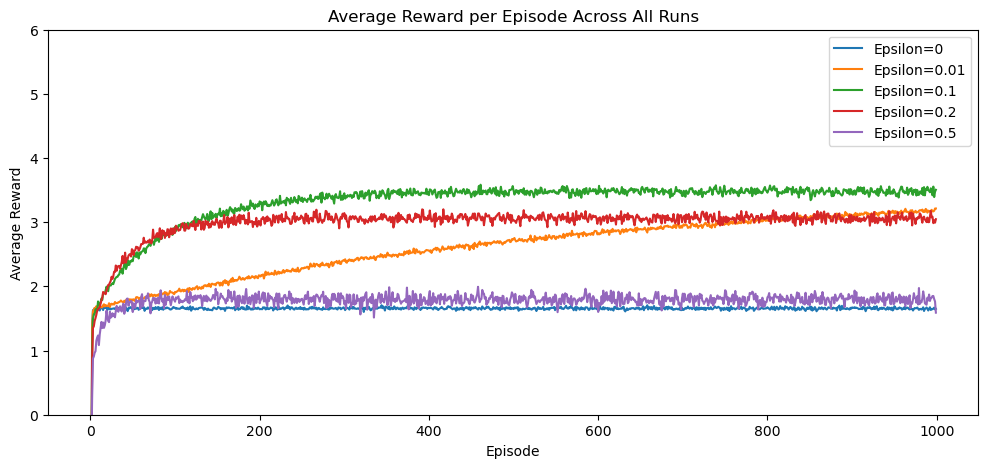

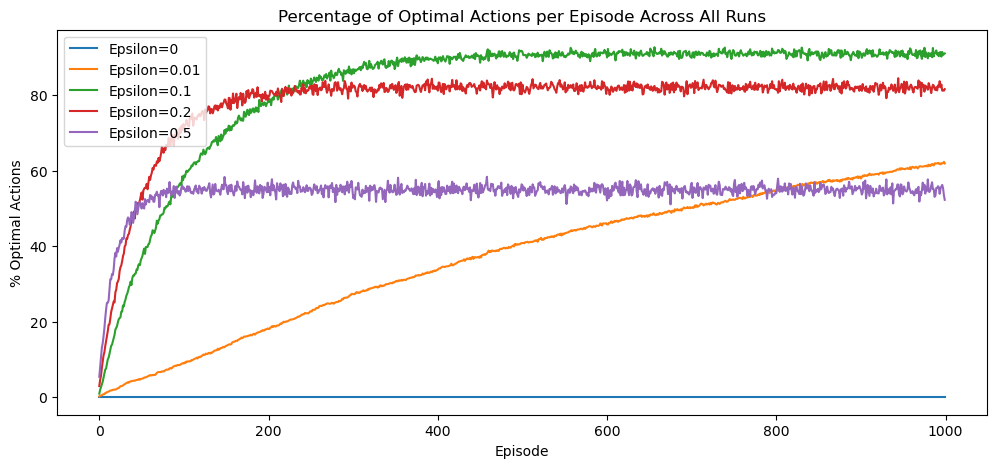

In [29]:
### THIS IS THE CODE USED FOR TESTING DIFFERENT ε  VALUES AND CREATING THE GRAPHS


# import matplotlib.pyplot as plt
# import numpy as np

# # Define the range of epsilon values to test
# epsilon_values = [0,0.01, 0.1, 0.2, 0.5]

# # Initialize dictionaries to store cumulative rewards and optimal action counts
# cumulative_rewards_per_episode = {epsilon: np.zeros(num_episodes) for epsilon in epsilon_values}
# optimal_action_counts_per_episode = {epsilon: np.zeros(num_episodes) for epsilon in epsilon_values}

# for epsilon in epsilon_values:
#     for i_run in range(num_runs):
#         agent = EplisonGreedyAgent(num_action, epsilon)

#         for episode in range(num_episodes):
#             action = agent.select_action()
#             _, reward, _, _ = env.step(action)
#             agent.update_parameters(action, reward)

#             # Add the reward to the cumulative sum for this episode
#             cumulative_rewards_per_episode[epsilon][episode] += reward

#             # Check if the selected action is the optimal action

#             if action == env.optimalM:
#                 optimal_action_counts_per_episode[epsilon][episode] += 1

# # Compute the average reward and the percentage of optimal actions per episode across all runs
# average_rewards_per_episode = {epsilon: rewards / num_runs for epsilon, rewards in cumulative_rewards_per_episode.items()}
# percentage_optimal_action_per_episode = {epsilon: (counts / num_runs) * 100 for epsilon, counts in optimal_action_counts_per_episode.items()}


# # Plotting Average Rewards per Episode
# plt.figure(figsize=(12, 5))
# for epsilon, rewards in average_rewards_per_episode.items():
#     plt.plot(range(num_episodes), rewards, label=f'Epsilon={epsilon}')
# plt.title('Average Reward per Episode Across All Runs')
# plt.xlabel('Episode')
# plt.ylabel('Average Reward')
# plt.legend()
# plt.ylim([0,6])
# plt.show()

# # Plotting Percentage of Optimal Actions per Episode
# plt.figure(figsize=(12, 5))
# for epsilon, percentages in percentage_optimal_action_per_episode.items():
#     plt.plot(range(num_episodes), percentages, label=f'Epsilon={epsilon}')
# plt.title('Percentage of Optimal Actions per Episode Across All Runs')
# plt.xlabel('Episode')
# plt.ylabel('% Optimal Actions')
# plt.legend()

# plt.show()


Now it's time to examine the performance of algorithms with different epsilon values (different exploration strategies) in multiple simulation runs. 

You shall play with the parameter epsilon under 2 or 3 different gambling environments (by initlizing different reward distributions for machines). **For each environment, try at least 2 different values of epsilon and identify a reasonable epsilon value that could balance the exploration and exploiation**. Instead of handing in your codes for this part, please select one environment you have tested and describe your environment and experimental settings **(1 point)**. Then, provide an explanation on how you identify the good epsilon value in this environment and why it is a good one **(1 point)**. 

Few instructions:
- Your answer shall include two plots presenting compariable measures of the different epsilon settings (e.g. the average reward per step and % of optimal action). **(1 point)** 
- You shall present the average results from at least 100 simulation runs. Remember that the gambling environment CANNOT be changed over those runs used for calculating the average results. 
- You may adjust the total time steps when the learning needs more time for a cerain epsilon value, but do not over spend your time on this.    

**Put your answer (at most 300 words) with accompanying plots here.**
We conducted an extensive simulation consisting of 2000 runs and 1000 episodes each, under a k-armed bandit framework represented by the GamblingRoom environment. This environment consisted of slot machines with reward distributions characterized by randomly initialized means (self.mu). The optimal action was thus defined as selecting the machine with the highest mean reward.

For the experimental setup, we tested five different epsilon values: [0, 0.01, 0.1, 0.2, 0.5]. These values span a range from pure exploitation (epsilon=0) to heavy exploration (epsilon=0.5). The goal was to find an epsilon that balances exploration  and exploitation.

Through these simulations, the epsilon value of 0.01 emerged as the most effective in balancing this trade-off. The accompanying plots of average rewards per episode and the percentage of optimal actions taken reveal that an epsilon of 0.01 consistently achieved high rewards quicker than the other values tested and maintained a high percentage of optimal actions throughout the 1000 episodes. It is important to mention that, as epsilon increases, the reward initially rises faster due to exploration but then it reaches a plateu or even decreases as the randomness starts to overshadow the exploitation of known information.

The graphical data highlights the effectiveness of using an epsilon of 0.01 in these simulations. The plots show that the average reward per episode stabilizes at a high value rapidly when epsilon is set to 0.01, demonstrating that the agent is effectively utilizing its understanding of the best slot machine. At the same time, a high proportion of optimal actions are consistently selected, indicating that the agent rarely engages in less advantageous choices throughout the episodes.

These results suggest that a small amount of exploration is sufficient for learning effective policies in this particular gambling environment, given its reward distribution. The epsilon value of 0.01 ensures that the agent explores just enough to identify the most rewarding machine without sacrificing the gains from exploiting this knowledge

You are almost done! Before handing in, make sure that the codes you hand in work, and that all plots are shown. **Submit just one file per team.** Please make sure that you submit a .zip file with images.

Again, make sure you name this file according to your last names.